# Zalando Clother Classification - Modeling and testing

__Author: Fernández Hernández, Alberto__

__Date: 2023 - 10 - 26__

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.0 MB/s eta 0:00:00


In [2]:
# -- Libraries
from   sklearn.model_selection import train_test_split
from   sklearn.utils           import class_weight
from   sklearn                 import metrics
from   torchvision             import models
from   tqdm                    import tqdm
from   torch.utils             import data
import torch.nn.functional     as F
import torch.nn                as nn
import matplotlib.pyplot       as plt
import numpy                   as np
import pandas                  as pd
import torchvision.transforms  as transforms
import itertools
import torch
import shap
import math
import gzip
import os

In [3]:
# -- Constants and parameters
MAIN_PATH       = '/content/drive/MyDrive/Personal/CentricSoftware'
NPY_FILES       = MAIN_PATH + '/images/'
MODELS_PATH     = MAIN_PATH + '/models/'
MODEL_NAME      = f'{MODELS_PATH}/01_zalando_image_classification_mobilenet_v2_baseline_layers_frozen_with_img_aug_v2.pth'
BATCH_SIZE      = 16
RANDOM_STATE    = 1234
EPOCHS          = 15
PATIENT         = 3
LEARNING_RATE   = 5e-05
LOSS_IMPROVE    = 1e-04
MAX_PIXEL_VALUE = 255
NUM_LABELS      = 5
IMG_SIZE        = 224

# -- Specify seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

LABEL_MAPPING = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

CATEGORY_MAPPING = {
    "T-shirt/top": "Upper part",
    "Pullover": "Upper part",
    "Coat": "Upper part",
    "Shirt": "Upper part",
    "Trouser": "Bottom part",
    "Dress": "One piece",
    "Sandal": "Footwear",
    "Sneaker": "Footwear",
    "Ankle boot": "Footwear",
    "Bag": "Bags"
}

GROUP_MAPPING = {
    "Upper part": 0,
    "Bottom part": 1,
    "One piece": 2,
    "Footwear": 3,
    "Bags": 4
}

REVERSE_GROUP_MAPPING = dict((v, k) for k, v in GROUP_MAPPING.items())

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
f=gzip.open('/content/drive/MyDrive/Personal/CentricSoftware/t10k-images-idx3-ubyte.gz','rb')
file_content=f.read()

In [6]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load data

In [7]:
X_train, y_train = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='train')

X_train          = np.reshape(X_train, (X_train.shape[0],
                                        int(math.sqrt(X_train.shape[1])),
                                        int(math.sqrt(X_train.shape[1]))
                                        )
                   )

X_test, y_test   = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='t10k')

X_test           = np.reshape(X_test, (X_test.shape[0],
                                        int(math.sqrt(X_test.shape[1])),
                                        int(math.sqrt(X_test.shape[1]))
                                        )
                   )

## Convert labels into groups

In [8]:
# -- Train labels
y_train_df = pd.DataFrame({'label': y_train})
y_train_df['label_str'] = y_train_df['label'].map(LABEL_MAPPING)

# -- Test labels
y_test_df = pd.DataFrame({'label': y_test})
y_test_df['label_str'] = y_test_df['label'].map(LABEL_MAPPING)

# -- Convert to groups
y_train_df['category'] = y_train_df['label_str'].map(CATEGORY_MAPPING)
y_test_df['category']  = y_test_df['label_str'].map(CATEGORY_MAPPING)

# -- Filter and rename columns
y_train_df = pd.DataFrame(y_train_df['category'].apply(lambda x: GROUP_MAPPING[x]))
y_test_df  = pd.DataFrame(y_test_df['category'].apply(lambda x: GROUP_MAPPING[x]))

y_train_df.rename(columns={'category': 'label'}, inplace=True)
y_test_df.rename(columns={'category': 'label'}, inplace=True)

### Perform train & validation split

In [9]:
y_train_df.reset_index(inplace=True)
X, y = y_train_df[['index']], y_train_df[['label']]
_, _, y_train_df, y_val_df = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [10]:
y_train_df.value_counts(sort=False)

label
0        19200
1         4800
2         4800
3        14400
4         4800
dtype: int64

In [11]:
y_val_df.value_counts(sort=False)

label
0        4800
1        1200
2        1200
3        3600
4        1200
dtype: int64

### Save images as .npy files

In [12]:
y_train_df.reset_index(inplace=True), y_val_df.reset_index(inplace=True), y_test_df.reset_index(inplace=True)

(None, None, None)

In [13]:
!mkdir $NPY_FILES
train_indexes_list = list(y_train_df['index'])
for index_ in tqdm(train_indexes_list):
  np.save(NPY_FILES + 'train_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 48000/48000 [04:00<00:00, 199.24it/s]


In [14]:
validation_indexes_list = list(y_val_df['index'])
for index_ in tqdm(validation_indexes_list):
  np.save(NPY_FILES + 'validation_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 12000/12000 [00:59<00:00, 200.36it/s]


In [15]:
test_indexes_list = list(y_test_df['index'])
for index_ in tqdm(test_indexes_list):
  np.save(NPY_FILES + 'test_image_{:05d}.npy'.format(index_), X_test[int(index_)])

100%|██████████| 10000/10000 [00:50<00:00, 196.82it/s]


__Get mean and standard deviation__

NOTE: MEAN and STD must be extracted ONLY from the training set

In [16]:
train_indexes_list = list(y_train_df['index'])
MEAN = np.mean(X_train[train_indexes_list,:,:]); STD = np.std(X_train[train_indexes_list,:,:])
MEAN, STD

(72.96911585884354, 90.03119247281305)

In [17]:
# -- Save labels as .csv files
y_train_df.to_csv(MAIN_PATH + '/train_labels.csv', sep=';', index=False)
y_val_df.to_csv(MAIN_PATH + '/val_labels.csv', sep=';', index=False)
y_test_df.to_csv(MAIN_PATH + '/test_labels.csv', sep=';', index=False)

# Define Model Architecture

In [18]:
# Step 1. Define ZalandoDataset class
class ZalandoDataset(data.Dataset):
    def __init__(self, transform=False, data_type='Train', images_list=None):
        super().__init__()
        self.transform    = transform
        self.data_type    = data_type
        self.images_list  = images_list
        self.records      = None

        if self.data_type == 'Train':
            self.labels      = pd.read_csv(MAIN_PATH + '/train_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'train_image' in file_]
        elif self.data_type == 'Validation':
            self.labels      = pd.read_csv(MAIN_PATH + '/val_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'validation_image' in file_]
        elif self.data_type == 'Test':
            self.labels      = pd.read_csv(MAIN_PATH + '/test_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'test_image' in file_]
        else:
          assert False, "data_type not admitted. Options available: Train, Validation or Test"

        # Label weights (inverse classes balance)
        labels_list   = list(self.labels['label'])
        weights_      = class_weight.compute_class_weight(class_weight='balanced',
                                                          classes=np.unique(labels_list),
                                                          y=np.array(labels_list))
        self.weights  = torch.FloatTensor(weights_)
        # -- NEW IN VERSION 01 - Applying image augmentation techniques
        if self.data_type == 'Train':
          self.transforms = transforms.Compose([
                                transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomRotation(10),            # -- Added in version 01
                                transforms.RandomHorizontalFlip(),        # -- Added in version 01
                                transforms.Normalize((MEAN,), (STD,)),
                                transforms.Lambda(lambda x: x.squeeze(0,1))
                            ])
        else:
          self.transforms = transforms.Compose([
                                transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.Normalize((MEAN,), (STD,)),
                                transforms.Lambda(lambda x: x.squeeze(0,1))
                            ])


    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.records)

    def __getitem__(self, index):
        # Load raw image data for each plane
        path    = self.records[index]
        image_id= int(path.split('_')[-1].replace('.npy', ''))
        img_raw = np.load(path)

        # Standarize data
        img_raw = torch.FloatTensor(img_raw)
        img_raw = self.transforms(img_raw)
        img_raw = img_raw.expand(3, img_raw.size(0), img_raw.size(1))

        label = list(self.labels[self.labels['index'] == image_id]['label'])
        label = torch.tensor(label)

        # Return pre-processed image and label
        return img_raw, label

In [19]:
# -- Number of total images: 70k
image_list = os.listdir(NPY_FILES)
len(image_list)

70000

In [20]:
# Get dataset
train_dataset = ZalandoDataset(images_list=image_list)
val_dataset   = ZalandoDataset(data_type='Validation', images_list=image_list)
test_dataset  = ZalandoDataset(data_type='Test', images_list=image_list)

In [21]:
train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE,
                shuffle=True, drop_last=False, num_workers=2)

val_loader  =  torch.utils.data.DataLoader(
                val_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

test_loader =  torch.utils.data.DataLoader(
                test_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

## Define the Conv. Model

In [22]:
class CustomMobileNetV2(nn.Module):
    """
    Define MobileNetV2 architecture, which consists of:
      - MobileNetV2
        - Conv2d
        - ...
        - nn.Linear(1280, num_classes)
    """
    def __init__(self, num_classes=NUM_LABELS):
        super(CustomMobileNetV2, self).__init__()

        # -- Load pretrained MobileNetV2
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)

        # -- Freeze convolutional layers
        for param in self.mobilenet_v2.parameters():
            param.requires_grad = False

        # -- Replace last layer by final FC with num_classes outputs
        self.mobilenet_v2.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [24]:
model = CustomMobileNetV2()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 36.9MB/s]


## Error + Callbacks

In [25]:
# Define error criterion and optimize functions
train_criterion = nn.CrossEntropyLoss(weight = train_dataset.weights)
val_criterion   = nn.CrossEntropyLoss(weight = val_dataset.weights)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=0.01)
# Define callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer, patience=3, factor=0.3, threshold=1e-4, verbose=True
)

## Define metrics

In [26]:
def get_metrics(y_true, y_pred):
    """
    Calculate recall (sensitivity), precision and negative predicted value (NPV) for a multi-class image classification task with N classes.

    Args:
    y_true (list): True labels (ground truth) for each sample.
    y_pred (list): Predicted labels for each sample.

    Returns:
    dict: A dictionary containing recall, precision and NPV for each class.
    """
    classes = range(5)
    sensitivity = {}  # Recall
    precision = {}
    npv = {}

    for c in classes:
        # Calculate True Positives (TP), False Negatives (FN), and False Positives (FP) for each class
        TP = sum((y_true[i][c] == 1) and (y_pred[i][c] == 1) for i in range(len(y_true)))
        TN = sum((y_true[i][c] == 0) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FN = sum((y_true[i][c] == 1) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FP = sum((y_true[i][c] == 0) and (y_pred[i][c] == 1) for i in range(len(y_true)))

        # Calculate recall (sensitivity) and precision for each class
        sensitivity[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FP) if (TP + FP) > 0 else 0
        npv[REVERSE_GROUP_MAPPING[c]] = TN / (TN + FN) if (TN) > 0 else 0

    return {"recall": sensitivity, "precision": precision, "negative predicted value": npv}

## Define training and validation metrics

In [27]:
# -- Transform predicted values into one-shot
def maximize_index(predicted_values):
  max_indices = np.argmax(predicted_values, axis=1)
  result = np.zeros_like(predicted_values)
  for i in range(result.shape[0]):
      result[i, max_indices[i]] = 1
  return result

In [28]:
# -- Define train function
def train(train_data, model, criterion):
    print('Training...')
    model.train()
    counter = 0
    train_running_loss    = 0.0
    prediction_list       = []
    prediction_proba_list = []
    for input_data, label in tqdm(train_data):
        # Switch to GPU if available
        if torch.cuda.is_available():
            input_data, label = input_data.cuda(), label.cuda()
        counter += 1
        optimizer.zero_grad()
        outputs = model(input_data)

        # Apply softmax activation to get all the outputs between 0 and 1
        outputs_sig  = F.softmax(outputs.data, dim=1).detach().cpu()
        prediction_proba_list.append(itertools.chain(*outputs_sig))
        prediction_list.append(itertools.chain(maximize_index(outputs_sig.numpy())))

        # Loss
        loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
        train_running_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    train_loss       = train_running_loss  / counter
    return train_loss, prediction_list

In [29]:
# Define val function
def val(val_data, model, criterion):
    print('Validating...')
    model.eval()
    counter = 0
    val_running_loss      = 0.0
    total                 = 0.0
    prediction_list       = []
    prediction_proba_list = []
    label_list            = []
    label_one_hot         = []

    with torch.no_grad():
      for input_data, label in tqdm(val_data):
          # Again, switch to GPU if available
          if torch.cuda.is_available():
              input_data, label = input_data.cuda(), label.cuda()

          label_numpy   = label.detach().cpu().numpy()
          for label_ in label_numpy:
            label_one_hot_aux = np.zeros(NUM_LABELS)
            label_one_hot_aux[label_] = 1
            label_one_hot.append(label_one_hot_aux)

          label_list.append(label_numpy)
          counter += 1
          outputs  = model(input_data)

          # Apply softmax activation to get all the outputs between 0 and 1
          outputs_sig = F.softmax(outputs.data, dim=1).detach().cpu()
          prediction_proba_list.append(outputs_sig)
          prediction_list.append(maximize_index(outputs_sig.numpy()))
          total    += label.size(1)

          # Loss
          loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
          val_running_loss += loss.item()

      val_loss     = val_running_loss / counter
      # Get Sensitivity/Precision/NPV
      prediction_list = list(itertools.chain(*prediction_list))
      label_list      = list(itertools.chain(*label_list))
      prediction_proba_list = list(itertools.chain(*prediction_proba_list))
      metric_dict  = get_metrics(label_one_hot, prediction_list)
    return val_loss, prediction_list, prediction_proba_list, metric_dict

### Define Main loop

In [ ]:
# start the training and validation
train_loss     = []
valid_loss     = []
total_train_predictions = []
total_val_predictions   = []

best_val_loss = float('inf')
best_val_auc  = float(0)

patient_counter = 0

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_predictions = train(
        train_loader, model, train_criterion
    )
    val_epoch_loss, val_predictions, val_predictions_proba, val_metric_dict = val(
        val_loader, model, val_criterion
    )

    # Call ReduceLR Callback (after validation step)
    scheduler.step(val_epoch_loss)

    if best_val_loss - val_epoch_loss >= LOSS_IMPROVE:
        print("Val loss has improved. From {} to {}. Saving model...".format(best_val_loss, val_epoch_loss))
        best_val_loss   = val_epoch_loss
        patient_counter = 0
        torch.save(model, MODEL_NAME)
    else:
        print("Val loss did not improve")
        patient_counter+=1
        if patient_counter == PATIENT:
            break

    train_loss.append(train_epoch_loss)
    valid_loss.append(val_epoch_loss)
    total_train_predictions.append(train_predictions)
    total_val_predictions.append(val_predictions)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    for k in val_metric_dict.keys():
      print(k)
      print("--------")
      for k_aux in val_metric_dict[k].keys():
        print(k_aux + ': ' + str(np.round(val_metric_dict[k][k_aux], 2)))
      print("-----------------------")
    print()
    print("-"*80)

Epoch 1 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From inf to 0.450864550113678. Saving model...
Train Loss: 0.7708
Val Loss: 0.4509
recall
--------
Upper part: 0.86
Bottom part: 0.96
One piece: 0.75
Footwear: 0.98
Bags: 0.9
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.9
One piece: 0.62
Footwear: 0.98
Bags: 0.83
-----------------------
negative predicted value
--------
Upper part: 0.91
Bottom part: 1.0
One piece: 0.97
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 2 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.450864550113678 to 0.36574356915553413. Saving model...
Train Loss: 0.4377
Val Loss: 0.3657
recall
--------
Upper part: 0.86
Bottom part: 0.95
One piece: 0.78
Footwear: 0.99
Bags: 0.9
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.94
One piece: 0.63
Footwear: 0.97
Bags: 0.86
-----------------------
negative predicted value
--------
Upper part: 0.91
Bottom part: 0.99
One piece: 0.97
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 3 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.36574356915553413 to 0.31213336953520776. Saving model...
Train Loss: 0.3685
Val Loss: 0.3121
recall
--------
Upper part: 0.87
Bottom part: 0.96
One piece: 0.8
Footwear: 0.99
Bags: 0.91
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.94
One piece: 0.63
Footwear: 0.99
Bags: 0.9
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 0.99
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 4 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.31213336953520776 to 0.29832507137954234. Saving model...
Train Loss: 0.3455
Val Loss: 0.2983
recall
--------
Upper part: 0.87
Bottom part: 0.96
One piece: 0.82
Footwear: 0.99
Bags: 0.9
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.94
One piece: 0.63
Footwear: 0.99
Bags: 0.93
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.98
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 5 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.29832507137954234 to 0.2727850269973278. Saving model...
Train Loss: 0.3302
Val Loss: 0.2728
recall
--------
Upper part: 0.87
Bottom part: 0.96
One piece: 0.84
Footwear: 0.99
Bags: 0.93
-----------------------
precision
--------
Upper part: 0.95
Bottom part: 0.96
One piece: 0.63
Footwear: 0.99
Bags: 0.91
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 6 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.3187
Val Loss: 0.2845
recall
--------
Upper part: 0.88
Bottom part: 0.96
One piece: 0.8
Footwear: 0.99
Bags: 0.9
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.93
One piece: 0.65
Footwear: 0.98
Bags: 0.93
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.98
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 7 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.2727850269973278 to 0.27100467946132023. Saving model...
Train Loss: 0.3109
Val Loss: 0.2710
recall
--------
Upper part: 0.88
Bottom part: 0.96
One piece: 0.81
Footwear: 0.99
Bags: 0.93
-----------------------
precision
--------
Upper part: 0.95
Bottom part: 0.95
One piece: 0.67
Footwear: 0.99
Bags: 0.88
-----------------------
negative predicted value
--------
Upper part: 0.92
Bottom part: 1.0
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 8 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.3030
Val Loss: 0.2710
recall
--------
Upper part: 0.86
Bottom part: 0.94
One piece: 0.86
Footwear: 0.99
Bags: 0.93
-----------------------
precision
--------
Upper part: 0.95
Bottom part: 0.98
One piece: 0.62
Footwear: 0.99
Bags: 0.89
-----------------------
negative predicted value
--------
Upper part: 0.91
Bottom part: 0.99
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 9 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.27100467946132023 to 0.25270638742049534. Saving model...
Train Loss: 0.3017
Val Loss: 0.2527
recall
--------
Upper part: 0.89
Bottom part: 0.96
One piece: 0.82
Footwear: 0.98
Bags: 0.93
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.95
One piece: 0.68
Footwear: 0.99
Bags: 0.89
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 10 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.3007
Val Loss: 0.2651
recall
--------
Upper part: 0.89
Bottom part: 0.97
One piece: 0.81
Footwear: 0.99
Bags: 0.92
-----------------------
precision
--------
Upper part: 0.95
Bottom part: 0.93
One piece: 0.67
Footwear: 0.99
Bags: 0.92
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.98
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 11 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.2939
Val Loss: 0.2615
recall
--------
Upper part: 0.88
Bottom part: 0.96
One piece: 0.82
Footwear: 0.99
Bags: 0.92
-----------------------
precision
--------
Upper part: 0.95
Bottom part: 0.96
One piece: 0.66
Footwear: 0.99
Bags: 0.91
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 1.0
One piece: 0.98
Footwear: 1.0
Bags: 0.99
-----------------------

--------------------------------------------------------------------------------
Epoch 12 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve


## Test inference

In [ ]:
# -- Use val function for test data
test_epoch_loss, test_predictions, test_predictions_proba, test_metric_dict = val(
        test_loader, best_model, val_criterion
)

for k in test_metric_dict.keys():
  print(k)
  print("--------")
  for k_aux in test_metric_dict[k].keys():
    print(k_aux + ': ' + str(np.round(test_metric_dict[k][k_aux], 2)))
  print("-----------------------")

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

recall
--------
Upper part: 0.86
Bottom part: 0.92
One piece: 0.82
Footwear: 0.99
Bags: 0.9
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.96
One piece: 0.61
Footwear: 0.98
Bags: 0.88
-----------------------
negative predicted value
--------
Upper part: 0.91
Bottom part: 0.99
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------


In [ ]:
# -- Use val function for test data - V2
test_epoch_loss, test_predictions, test_predictions_proba, test_metric_dict = val(
        test_loader, best_model, val_criterion
)

for k in test_metric_dict.keys():
  print(k)
  print("--------")
  for k_aux in test_metric_dict[k].keys():
    print(k_aux + ': ' + str(np.round(test_metric_dict[k][k_aux], 2)))
  print("-----------------------")

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

recall
--------
Upper part: 0.89
Bottom part: 0.94
One piece: 0.8
Footwear: 0.98
Bags: 0.92
-----------------------
precision
--------
Upper part: 0.94
Bottom part: 0.95
One piece: 0.67
Footwear: 0.99
Bags: 0.89
-----------------------
negative predicted value
--------
Upper part: 0.93
Bottom part: 0.99
One piece: 0.98
Footwear: 0.99
Bags: 0.99
-----------------------


### Confussion matrix

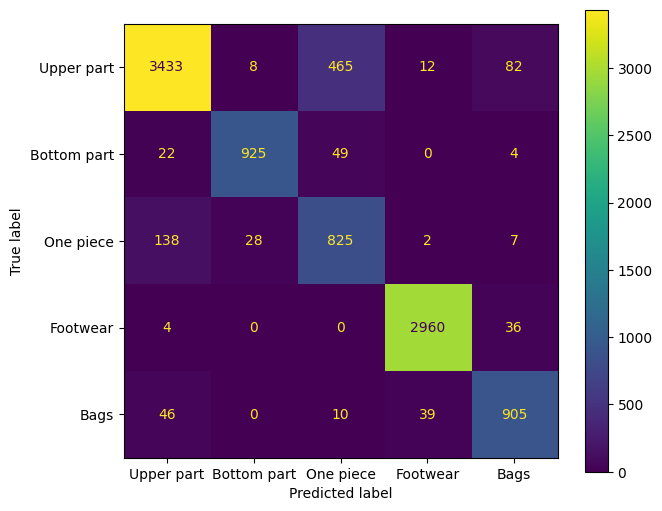

In [ ]:
# -- With data augmentation (plus erasing)
real = list(y_test_df['label'])
pred = [np.argmax(pred) for pred in test_predictions]

cm   = metrics.confusion_matrix(real, pred, labels=list(REVERSE_GROUP_MAPPING.keys()))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GROUP_MAPPING.keys())
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax)
plt.show()

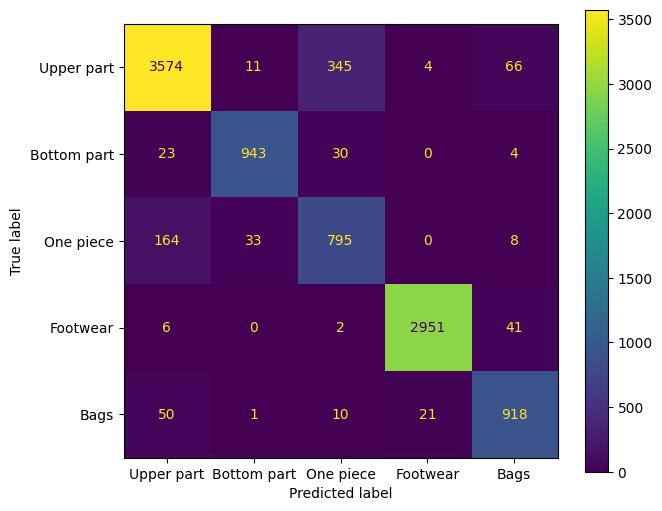

In [ ]:
# -- Without data augmentation (no erasing)
real = list(y_test_df['label'])
pred = [np.argmax(pred) for pred in test_predictions]

cm   = metrics.confusion_matrix(real, pred, labels=list(REVERSE_GROUP_MAPPING.keys()))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GROUP_MAPPING.keys())
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax)
plt.show()

## Slot for NOTES

* 01_zalando_image_classification_mobilenet_v2_baseline_layers_frozen_with_img_aug:
  * Model tends to confuse One piece clothes with Upper part ones
  * To sum up: the model is struggling with One Piece clothes

## Error analysis

In [ ]:
probabilities = [float(torch.max(proba)) for proba in test_predictions_proba]

y_test_df['pred_label']   = list(map(lambda x: REVERSE_GROUP_MAPPING[x], pred))
y_test_df['str_label']    = y_test_df['label'].apply(lambda x: REVERSE_GROUP_MAPPING[x])
y_test_df['proba_label']  = probabilities

y_test_df

,index,label,pred_label,str_label,proba_label
0,0,3,Footwear,Footwear,0.979650
1,1,0,Upper part,Upper part,0.851155
2,2,1,Bottom part,Bottom part,0.984381
3,3,1,Bottom part,Bottom part,0.949626
4,4,0,Upper part,Upper part,0.713902
...,...,...,...,...,...
9995,9995,3,Footwear,Footwear,0.843295
9996,9996,1,Bottom part,Bottom part,0.537488
9997,9997,4,Bags,Bags,0.973903
9998,9998,1,Bottom part,Bottom part,0.984537


* 01_zalando_image_classification_mobilenet_v2_baseline_layers_frozen_with_img_aug: model tend to confuse One piece clothes with Upper part ones

In [ ]:
y_test_df[(y_test_df['str_label'] == 'Upper part') &\
          (y_test_df['pred_label'] == 'One piece') &\
          (y_test_df['proba_label'] < 0.5)].sort_values('proba_label', ascending=True)

,index,label,pred_label,str_label,proba_label
2597,2597,0,One piece,Upper part,0.311859
7301,7301,0,One piece,Upper part,0.324473
9261,9261,0,One piece,Upper part,0.365585
2299,2299,0,One piece,Upper part,0.367632
3386,3386,0,One piece,Upper part,0.370274
9429,9429,0,One piece,Upper part,0.374814
894,894,0,One piece,Upper part,0.381565
8375,8375,0,One piece,Upper part,0.389345
2820,2820,0,One piece,Upper part,0.390915
577,577,0,One piece,Upper part,0.394993


In [ ]:
indexes = list(y_test_df[(y_test_df['str_label'] == 'Upper part') &\
                         (y_test_df['pred_label'] == 'One piece') &\
                         (y_test_df['proba_label'] < 0.5)]['index']
               )

Image number 66


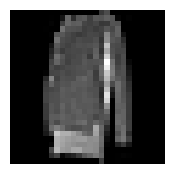

--------------------
Image number 499


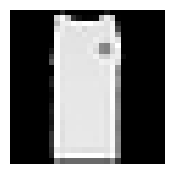

--------------------
Image number 577


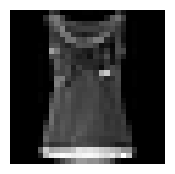

--------------------
Image number 858


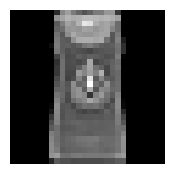

--------------------
Image number 888


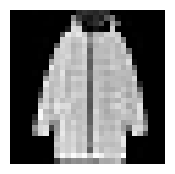

--------------------
Image number 894


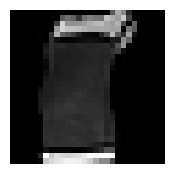

--------------------
Image number 916


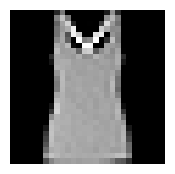

--------------------
Image number 948


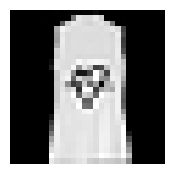

--------------------
Image number 985


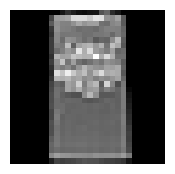

--------------------
Image number 1249


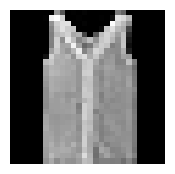

--------------------
Image number 1262


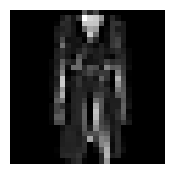

--------------------
Image number 2298


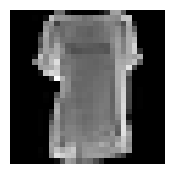

--------------------
Image number 2299


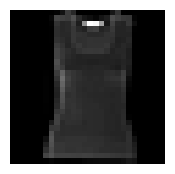

--------------------
Image number 2597


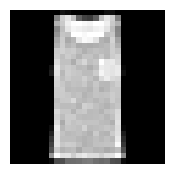

--------------------
Image number 2641


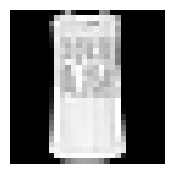

--------------------
Image number 2778


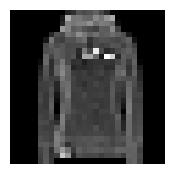

--------------------
Image number 2820


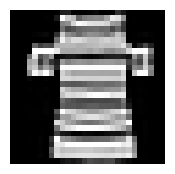

--------------------
Image number 2956


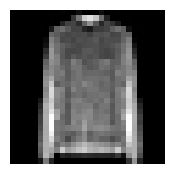

--------------------
Image number 3205


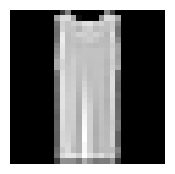

--------------------
Image number 3386


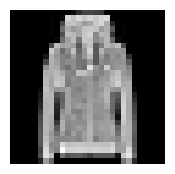

--------------------
Image number 3681


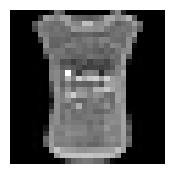

--------------------
Image number 4325


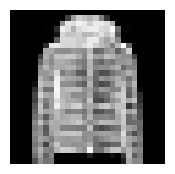

--------------------
Image number 5006


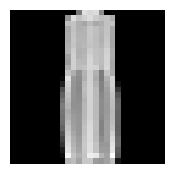

--------------------
Image number 5244


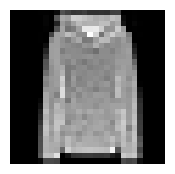

--------------------
Image number 5248


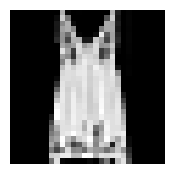

--------------------
Image number 5297


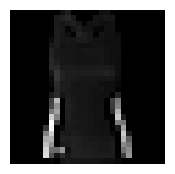

--------------------
Image number 5977


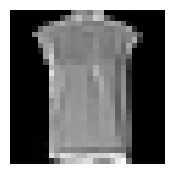

--------------------
Image number 6398


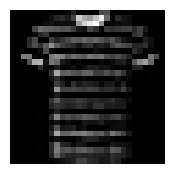

--------------------
Image number 6874


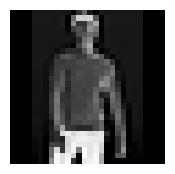

--------------------
Image number 7059


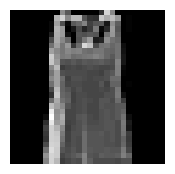

--------------------
Image number 7301


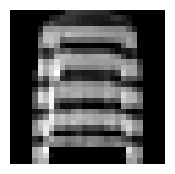

--------------------
Image number 7346


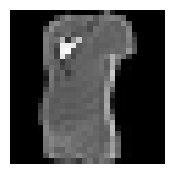

--------------------
Image number 7839


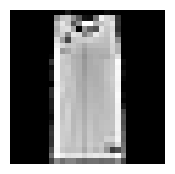

--------------------
Image number 7977


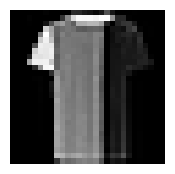

--------------------
Image number 8375


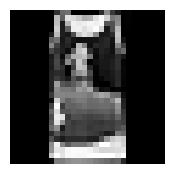

--------------------
Image number 8425


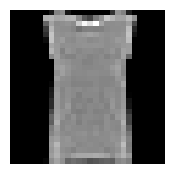

--------------------
Image number 8984


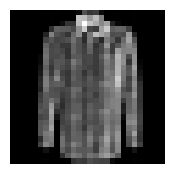

--------------------
Image number 9021


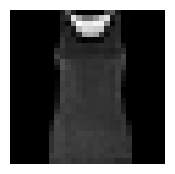

--------------------
Image number 9185


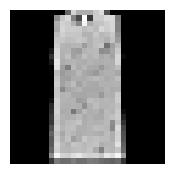

--------------------
Image number 9261


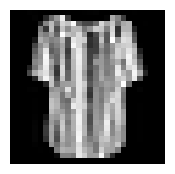

--------------------
Image number 9423


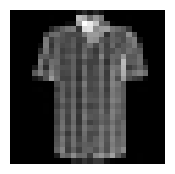

--------------------
Image number 9429


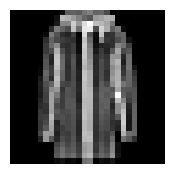

--------------------
Image number 9541


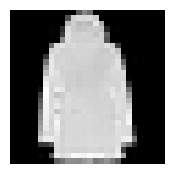

--------------------
Image number 9601


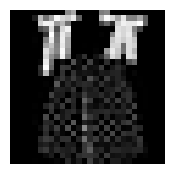

--------------------
Image number 9867


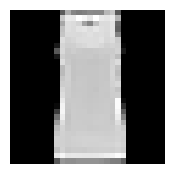

--------------------


In [ ]:
for index_ in indexes:
  plt.figure(figsize=(2, 2))
  print("Image number {}".format(index_))
  image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
  plt.imshow(image, cmap='gray', aspect='auto')
  plt.axis('off')
  plt.show()
  print("-" * 20)

## ExplainableAI with Shap

* 01_zalando_image_classification_mobilenet_v2_baseline_layers_frozen_with_img_aug: model tend to confuse One piece clothes with Upper part ones

__Define chunk to run exAI with Shap values__

In [ ]:
# -- Load model
best_model = torch.load(MODEL_NAME)
if torch.cuda.is_available():
  best_model.to('cuda')

# -- Define transform functions
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

# -- Define predict function
def predict(image):
    image  = torch.FloatTensor(image)
    if torch.cuda.is_available():
        image = image.cuda()
    output = model(image)
    return output

# -- 1. Create an explainer with model and image masker
# -- 2. Define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur({},{})".format(IMG_SIZE, IMG_SIZE), (3, IMG_SIZE, IMG_SIZE))

# -- Sample with image number 2191 (shirt)
explainer  = shap.Explainer(predict, masker_blur)
image_list = []
for index_ in indexes:
    if index_ == 888:
      image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
      image = torch.FloatTensor(image)
      image = transform(image)
      image = image.expand(3, image.size(1), image.size(2))
      image = torch.unsqueeze(image, 0)  # Añade la dimensión batch
      if torch.cuda.is_available():
          image = image.cuda()
      image_list.append(image)

shap_values = explainer(
    image_list[0],
    max_evals=1000,
    batch_size=1,
    outputs=shap.Explanation.argsort.flip[:1],
)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:28, 88.13s/it]               


In [ ]:
# -- Define inverse transform function (to "unstandardize data")
inv_transform = [
    transforms.Normalize(
        mean=(-1 * np.array(MEAN) / np.array(STD)).tolist(),
        std=(1 / np.array(STD)).tolist(),
    )
]
shap_values_data = np.moveaxis((shap_values.data * STD + MEAN).cpu().numpy()[0], 0, -1)
shap_values_values = [np.moveaxis(val, 0, -1) for val in np.moveaxis(shap_values.values[0], -1, 0)]

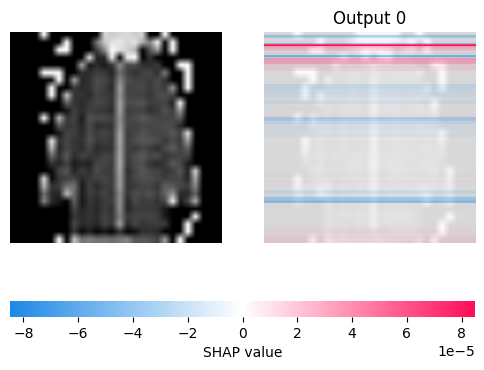

In [ ]:
shap.image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels=shap_values.output_names
)

## Conclusions for next experiments

* __In spite of applying data augmentation to the model, the results obtained remain consistent, and in the case of the "One Piece" label, they actually worsen compared to the previous baseline.__

* __Instead of freezing convolutional layers, what if we fine-tune all layers?__
* Next step: __Apply fine tuning without freezing convolutional layers__

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Upper part       | __0.91__  | __0.96__      | __0.94__                     | MobileNetV2 baseline (no img aug) - frozen layers |
| Upper part       | 0.89  | 0.94      | 0.93                     | MobileNetV2 baseline (best img aug) - frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Bottom part      | __0.96__  | __0.97__      | __1.0__                      | MobileNetV2 baseline (no img aug) - frozen layers |
| Bottom part      | 0.94  | 0.95      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| One piece        | __0.88__  | __0.73__      | __0.99__                     | MobileNetV2 baseline (no img aug) - frozen layers |
| One piece        | 0.8  | 0.67      | 0.98                     | MobileNetV2 baseline (best img aug) - frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Footwear         | __0.99__  | __0.99__      | __1.0__                      | MobileNetV2 baseline (no img aug) - frozen layers |
| Footwear         | 0.98  | 0.99      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Bags             | __0.96__  | __0.92__      | __1.0__                      | MobileNetV2 baseline (no img aug) - frozen layers |
| Bags             | 0.92  | 0.89      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |

* __Baseline model achieves better results__

* __Performance with best MobileNetV2 (no image augmentation + frozen layers)__

|                  | number of parameters | model size (MB) | test inference time (seconds) |
|------------------|-------|-----------|--------------------------|
| | 2230277 | 8.8 MB | 37.6 sec |

In [40]:
# Define test-inference function
def simple_test(test_data, model):
    print('Validating...')
    model.eval()
    prediction_proba_list = []
    label_list = []
    prediction_list = []
    with torch.no_grad():
      for input_data, label in tqdm(test_data):
          # Again, switch to GPU if available
          if torch.cuda.is_available():
              input_data, label = input_data.cuda(), label.cuda()

          label_numpy = label.detach().cpu().numpy()
          label_list.append(label_numpy)

          outputs  = model(input_data)

          # Apply softmax activation to get all the outputs between 0 and 1
          outputs_sig = F.softmax(outputs.data, dim=1).detach().cpu()
          prediction_list.append(maximize_index(outputs_sig.numpy()))
      # Get Sensitivity/Precision/NPV
      prediction_list = list(itertools.chain(*prediction_list))
      label_list      = list(itertools.chain(*label_list))

best_model = torch.load('/content/00_zalando_image_classification_mobilenet_v2_baseline_no_img_aug.pth')

%%time
# -- Sample inference-test function
simple_test(
        test_loader, best_model
)

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

CPU times: user 11.2 s, sys: 2.01 s, total: 13.2 s
Wall time: 37.6 s


In [44]:
params = sum([np.prod(p.size()) for p in best_model.parameters()])
params

2230277